In [45]:
TRADING_ENV_DICT = {1: "Quantopian Algorithm", 2: "Quantopian Notebook", 3: "pylivetrader Paper", 4: "pylivetrader live", 5: "zipline qundl notebook"}
TRADING_ENV = 5
MINUTES_PER_DAY = 450

#!pip install ta-lib
import numpy as np
import pandas as pd
import talib
# import matplotlib.pyplot as plt

import datetime
from talib import ATR

def preview(ab):
    info('\n %s ' % ab.tail())
    return ab

def load_pipeline_pattern(context):
    url = 'https://dl.dropboxusercontent.com/s/4gntd8z99d45sw2/ab_patterns_aug24.csv'
    fetch_csv(url,
                date_column    = 'date',
                date_format    = '%m/%d/%y',
                symbol_column  = 'symbol',
                pre_func       = preview)
    context.ab_stops = {}

def get_this_day():
    if TRADING_ENV in {1, 5}:
        return get_datetime()
    elif TRADING_ENV in {3, 4}:
        return pd.Timestamp.now(tz)

def update_dataframe_ab_signal(context, data=None):
    '''
    Update buy and sell symbol list from Pandas.dataframe -- context.ab_patterns
    '''
    info(" update_dataframe_ab_signal starts ")
    for security in list(context.security_list):
        this_day =  get_this_day() 
        symbol_pattern = context.ab_patterns[context.ab_patterns['symbol']==security.symbol]

        if not (security in context.ab_data):
            context.ab_data[security] = {}
        context.ab_data[security]["last_confirmed"] = \
            get_symbol_pattern_information(\
                symbol_pattern[symbol_pattern['confirmation_date']<=this_day], \
                sort_column='confirmation_date')
        context.ab_data[security]["latest"] = \
            get_symbol_pattern_information(\
                symbol_pattern[symbol_pattern['date']<=this_day])
        info("Latest AB Data: {}".format(context.ab_data[security]["latest"]))
        info("Last Confirmed AB Data: {}".format(context.ab_data[security]["last_confirmed"]))

    info(" update_dataframe_ab_signal done ")


def update_pipeline_ab_signal(context, data):
    '''
    Update buy and sell symbol list when AB data build in pipeline, which running on Quantopian.com or fipy.me
    But because pylivetrader doesn't support fetch_csv function, need to load use Pandas
    '''
    #----------------------------
    # Reset timing back to 0
    #----------------------------
    context.num_trading_min = 0

    for security in list(context.security_list):
        # -------------------------
        # AB Data
        # -------------------------
        pattern_name, buy_level, stop_loss, sell_level, \
        confirmation_level, confirmation_date, signal = \
        data.current(security, ['pattern','buy_level', \
                                'stop_loss', 'sell_level', \
                                'confirmation_level', 'confirmation_date', \
                                'signal'])
        
        context.ab_data[security]["used"] = False

        info("{} {} {} {} {} {} {}".format(pattern_name, buy_level, \
                                            stop_loss, sell_level, confirmation_level, \
                                            confirmation_date, signal))


        context.ab_data[security]['latest'] = {
                 "pattern_name": pattern_name, 
                 "buy_level": buy_level, 
                 "stop_loss": stop_loss, 
                 "sell_level": sell_level,
                 "confirmation_level": np.nan,
                 "confirmation_date": np.nan, 
                 "signal": np.nan
            }
 
        #-----------------------
        # If Latest Signal is confirmed, only confirm it on the date
        #-----------------------
        if not pd.isnull(confirmation_date):
            this_day = get_this_day()
            confimation_day = pd.Timestamp(confirmation_date, tz=this_day.tz)
            # last_trading_day = tc.previous_close(this_day)
            
            td = this_day - confimation_day

            #-----------------------
            # Signal Unconfirmed at this point
            #-----------------------
            # if (confimation_day > this_day):
            if (confimation_day <= this_day):
                context.ab_data[security]["latest"]["confirmation_level"] = confirmation_level
                context.ab_data[security]["latest"]["confirmation_date"] = confirmation_date
                context.ab_data[security]["latest"]["signal"] = signal
                
                context.ab_data[security]['last_confirmed'] = {
                     "pattern_name": pattern_name, 
                     "buy_level": buy_level, 
                     "stop_loss": stop_loss, 
                     "sell_level": sell_level,
                     "confirmation_level": confirmation_level,
                     "confirmation_date": confirmation_date, 
                     "signal": signal
                }

        info("Latest AB Data: {}".format(context.ab_data[security]["latest"]))
        info("Last Confirmed AB Data: {}".format(context.ab_data[security]["last_confirmed"]))

def cal_mavg_short_long(data, security, context):
    if data==None:
        return

    short_data = data.history(security, 'price', bar_count=5 * MINUTES_PER_DAY, frequency="1m").dropna()
    long_data = data.history(security, 'price', bar_count=13 * MINUTES_PER_DAY, frequency="1m").dropna()
    short_mavg = short_data.mean()
    long_mavg = long_data.mean()

    context.short_mavg[security] = short_mavg
    context.long_mavg[security] = long_mavg

if TRADING_ENV == 1:
    from quantopian.algorithm import attach_pipeline, schedule_function, pipeline_output
    import quantopian.algorithm as algo
    from quantopian.pipeline import Pipeline
    from quantopian.pipeline.data.builtin import USEquityPricing
    from quantopian.pipeline.filters import QTradableStocksUS
    from quantopian.pipeline.filters import StaticAssets
    load_pattern = load_pipeline_pattern
    update_ab_signal = update_pipeline_ab_signal

elif TRADING_ENV in {3,4,5}:
    # refering to https://www.quantopian.com/algorithms/5ee42350bf88df0042c8a5ed
    # and https://www.quantopian.com/posts/guide-for-porting-your-algorithms-to-a-local-zipline-research-environment
    # StaticAsset refers to https://www.quantopian.com/posts/exclude-stocks-from-pipeline-by-sid
    # from zipline.api import *
    import zipline.algorithm as algo
    from zipline.pipeline import Pipeline
    from zipline.pipeline.filters import StaticAssets 
    from zipline.finance.execution import StopOrder
    from zipline.utils.calendars import get_calendar  
    from logbook import Logger, set_datetime_format
    from pytz import timezone
    set_datetime_format(lambda :datetime.datetime.now(tz=timezone('US/Pacific')))
    log = Logger("Aegis")
    info = log.info
    debug = log.debug
    
    def null_print(s):
        pass

    if TRADING_ENV==5:
        from zipline.api import *
        from zipline.pipeline.data import USEquityPricing
        import matplotlib.pyplot as plt
        info = print
        debug = print
    else:
        from pylivetrader.api import order_target, symbol, get_open_orders
        from pipeline_live.data.alpaca.pricing import USEquityPricing
        from pylivetrader.finance.execution import LimitOrder, StopOrder

    from pytz import timezone
    tz = timezone('PST8PDT')

    def numpy_load_ab_pattern(context):
        url = 'http://stock-data.fipy.me/ab_patterns_extend.csv'
        date_cols = ['date', 'confirmation_date']
        context.ab_patterns = pd.read_csv(url, parse_dates=date_cols)
        info(context.ab_patterns.head())
    load_pattern = numpy_load_ab_pattern
    update_ab_signal = update_dataframe_ab_signal

def get_my_static_list():
    if TRADING_ENV in {1,3,5}:
        return [symbol('TQQQ')]

    ibd50 = [symbol('CHGG'), symbol('AMD'), symbol('VRTX'), symbol('NFLX'), symbol('VEEV'), symbol('FNV'), symbol('NOW'), symbol('TW'), symbol('NVDA'), symbol('ADBE'), symbol('ZYXI'), symbol('SFM'), symbol('KL'), symbol('GDDY'), symbol('BMY'), symbol('MRCY'), symbol('KLAC'), symbol('RMD'), symbol('FB'), symbol('ZM'), symbol('GSX'), symbol('AMT'), symbol('TSM'), symbol('DXCM'), symbol('PFSI'), symbol('DBX'), symbol('AMAT'), symbol('SIMO'), symbol('MODN'), symbol('ANTM'), symbol('PETS'), symbol('AAON'), symbol('WDAY'), symbol('ADSK'), symbol('VIRT'), symbol('ARE'), symbol('BOX'), symbol('TTC'), symbol('MPW'), symbol('TRNO'), symbol('HIW'), symbol('CTRE'), symbol('KRC'), symbol('AUDC'), symbol('FTNT'), symbol('QDEL'), symbol('TREX')]
    bear_and_bull_etf = [symbol('SDOW'), symbol('TQQQ'), symbol('TZA'), symbol('SQQQ'), symbol('TNA'), symbol('FAZ'), symbol('UDOW'), symbol('FAS'), symbol('QQQ'), symbol('PSQ'), symbol('SPXU'), symbol('UPRO'), symbol('SMDD'), symbol('UMDD'), symbol('SRTY'), symbol('URTY'), symbol('SDD'), symbol('SAA')]
    return ibd50 + bear_and_bull_etf
    
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.buy_today = set()
    context.sell_today = set()
    context.ab_patterns = None
    context.ab_data = {}
    context.ab_stops = {}
    context.short_mavg = {}
    context.long_mavg = {}
    context.atr_stoploss = {}
    context.num_trading_min = 0
    
    
    context.params = {'start_trade_after_market_open_hours': 0.5, 'pct_init': 0.03, 'pct_trail': 0.04, 'days_wait_max': 4, 'atr_stop_days': 14, 'atr_times_sigma': 2.0, 'bar_counts': {'short': 5, 'long': 13}}
    
    # Create our dynamic stock selector.
    # attach_pipeline(make_pipeline(), 'pipeline')

    # Record tracking variables at the end of each day.
    schedule_function(
        record_vars,
        date_rules.every_day(),
        time_rules.market_close(),
    )

    # Load AB data
    load_pattern(context)
    context.security_list = get_my_static_list()
    for security in list(context.security_list):
        context.ab_data[security] = {}
        context.ab_data[security]['last_confirmed'] = {}
#         context.ab_data[security]["open_price"] = np.nan
#         context.ab_data[security]["previous_closing_price"] = np.nan

    if TRADING_ENV != 1:
        update_ab_signal(context)

def make_pipeline():
    """
    A function to create our dynamic stock selector (pipeline). Documentation
    on pipeline can be found here:
    https://www.quantopian.com/help#pipeline-title
    """

    # Base universe set to the QTradableStocksUS
    # base_universe = QTradableStocksUS()
    
    sa = StaticAssets(get_my_static_list())

    # Factor of yesterday's close price.
    yesterday_close = USEquityPricing.close.latest

    pipe = Pipeline(
        columns={
            'close': yesterday_close,
        },
        screen=sa
    )
    return pipe

def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    debug("Today:{}, Daily holding {}".format(get_this_day(), context.portfolio.positions))
    # context.output = pipeline_output('pipeline')
    context.short_mavg = {}
    context.long_mavg = {}
    context.atr_stoploss = {}
    context.num_trading_min = 0
    # These are the securities that we are interested in trading each day.
    # context.security_list = context.output.index
    context.security_list = get_my_static_list()
    
    for security in list(context.security_list):
        context.ab_data[security]["open_price"] = np.nan
        context.ab_data[security]["previous_closing_price"] = np.nan
        
    if TRADING_ENV != 1:
        load_pattern(context)
        update_ab_signal(context, data) 

def get_symbol_pattern_information(symbol_pattern, sort_column='date'):
    if symbol_pattern.empty or (len(symbol_pattern.values)==0):
        return {}
    latest_pattern = symbol_pattern.sort_values(sort_column, ascending=False).iloc[0, :]
    return {
            "date": latest_pattern['date'], 
            "pattern_name": latest_pattern['pattern'],
            "buy_level": latest_pattern['buy_level'],
            "stop_loss": latest_pattern['stop_loss'],
            "sell_level": latest_pattern['sell_level'], 
            "confirmation_level": latest_pattern['confirmation_level'], 
            "confirmation_date": latest_pattern['confirmation_date'],
            "signal": latest_pattern['signal'],
            "type": latest_pattern['type'],
            "patterns_total": latest_pattern['patterns_total'],
            "confirmed_total": latest_pattern['confirmed_total'],
            "profitable_signals": latest_pattern['profitable_signals'],
            "confirmation": latest_pattern['confirmation'],
            "profitable_signal": latest_pattern['profitable_signal'],
            "profit": latest_pattern['profit'],
            "loss": latest_pattern['loss'],
            "total_net": latest_pattern['total_net']
    }

def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    # info("{} positions {}".format(get_datetime(), context.portfolio))
    if TRADING_ENV in {1,3,5}:
        update_ab_signal(context, data)

        

def get_atr_trail_percent(data, security, context):
    '''
    Return ATR (Average Trading Randing) Percent for Trailing Stop Loss
    ATR is using 35 moving prices
    '''
    highs = data.history(security, 'high', 35 * MINUTES_PER_DAY, '1m').dropna()
    lows = data.history(security, 'low', 35 * MINUTES_PER_DAY, '1m').dropna()
    closes = data.history(security, 'close', 35 * MINUTES_PER_DAY, '1m').dropna()
    current_price  = data.current(security, 'price')

    atr_stop_price_delta = ATR(highs, lows, closes, timeperiod=context.params['atr_stop_days'])[-1]
    
    context.atr_stoploss[security] = atr_stop_price_delta
    #context.params['atr_times_sigma'] * (atr_stop_price_delta / current_price)


def handle_data(context, data):
    """
    Called every minute.
    """
    if TRADING_ENV in {1,3, 5}:
        context.num_trading_min += 1
        number_of_min_to_skip = 30
        current_system_time = get_this_day()

#         info("Current System Time: {}".format(current_system_time))
#         info("Current Price:{}".format(data.current(context.security_list, 'price')))
        # -----------------------------------------------------
        # Record Open Price
        # -----------------------------------------------------
        if context.num_trading_min < number_of_min_to_skip:
            # -----------------------------------------------------
            # Record Open Price
            # -----------------------------------------------------
            for security in context.security_list:
                if np.isnan(context.ab_data[security]["open_price"]):
                    open_price = data.current(security, 'price')
                    previous_closing_price = data.history(security, 'price', bar_count=2, frequency="1m").dropna()[0]
                
                    info("Current System Time: {}".format(current_system_time))
                    info("Open Price:{}".format(open_price))
                    info("Previous Closing Price:{}".format(previous_closing_price))
                
                    context.ab_data[security]["open_price"] = open_price
                    context.ab_data[security]["previous_closing_price"] = previous_closing_price
            return

        
        for security in context.security_list:
            # debug("Time: {}, Current Price:{}".format(get_datetime(), data.current(security, 'price')))
            if security in context.ab_data:
                if (security not in context.short_mavg) or (security not in context.long_mavg):
                    cal_mavg_short_long(data, security, context)
                    get_atr_trail_percent(data, security, context)
                    
                if not context.ab_data[security].get("used", False):
                    if "latest" in context.ab_data[security]:
                        num_min_avg = 10
                        # -----------------------------------------------------
                        # Buy / Sell Logic
                        # -----------------------------------------------------
                        current_price = data.history(security, 'price',\
                                                bar_count=num_min_avg, frequency='1m').dropna().median()
                        
                        open_price = context.ab_data[security]["open_price"]
                        previous_closing_price = context.ab_data[security]["previous_closing_price"]

                        last_ab_record = context.ab_data[security]["latest"]
                        last_confirmed_ab_record = context.ab_data[security]["last_confirmed"]
                        last_ab_pattern = last_ab_record['pattern_name']
                        

                        last_ab_buy_level = float(last_ab_record['buy_level'])
                        last_ab_stop_loss = float(last_ab_record['stop_loss'])
                        last_ab_sell_level = float(last_ab_record['sell_level'])
                        
                        last_ab_signal = last_ab_record['signal']
                        
                        last_ab_confirmation_level = \
                        float(last_ab_record['confirmation_level'])
                        
                        last_ab_confirmation_date = \
                        last_ab_record['confirmation_date']
                        
                        # -----------------------------------------
                        # Last Confirmed AB Signal
                        # -----------------------------------------
                        if bool(last_confirmed_ab_record):
                        
                            last_confirmed_ab_signal = last_confirmed_ab_record['signal']

                            last_confirmed_ab_confirmation_level = \
                            float(last_confirmed_ab_record['confirmation_level'])

                            last_confirmed_ab_confirmation_date = \
                            last_confirmed_ab_record['confirmation_date']
                        
                        #Moving Average
                        short_mavg = context.short_mavg[security]
                        long_mavg = context.long_mavg[security]
                        
                        # ATR StopLoss
                        atr_stoploss = open_price - context.atr_stoploss[security]
                        
                        if context.num_trading_min==60:
                            debug("current_price {:.2f}".format(current_price))
                            debug("AB Pattern:{}, buy_level:{:.2f}, stop_loss:{:.2f}, sell_level:{:.2f}".format(last_ab_pattern, last_ab_buy_level, last_ab_stop_loss, last_ab_sell_level))
                            debug("short_mavg:{:.2f}, long_mavg:{:.2f}, atr_stoploss:{:.2f}".format(short_mavg, long_mavg, atr_stoploss))

                        record(TQQQ=current_price, short_mavg=short_mavg, long_mavg=long_mavg, atr_stoploss=atr_stoploss)

                        #
                        # Trading Logic: Buy
                        #
                        if (context.portfolio.positions[security].amount <= 0):

                            perform_buy = False
                            buy_reason = []
                            buy_check_mvg_cross = False
                            buy_check_AB = False
                            buy_check_atr_stoploss = False
                            
                            #----------------------
                            # Do not use signal
                            #----------------------
                            #buy_check_mvg_cross = True

                            # 
                            # Make Buy Decision
                            # 

                            # Check if short_mavg > long_mavg
                            #info("MAvg Short/Long: {} / {}".format(short_mavg, long_mavg))
                            if (short_mavg > long_mavg):
                                buy_check_mvg_cross = True
                                buy_reason.append("Short_Mavg > Long_Mavg")

                            #
                            # Auto Intraday Buy Confirmed
                            # 
                            if ("BULLISH" in last_ab_pattern):
                                
                                if (current_price > last_ab_buy_level):
                                    buy_check_AB = True
                                    buy_reason.append("AB Intraday Buy Confirmed using Buy Level")
                                
                                if (last_ab_buy_level is None and \
                                      current_price > last_ab_stop_loss):
                                    buy_check_AB = True
                                    buy_reason.append("AB Intraday Buy Confirmed using BULLISH STOP LOSS")

                            #
                            # AB Buy Confirmed
                            # 
                            if (last_ab_signal == 'BUY'):
                                buy_check_AB = True
                                buy_reason.append("AB Buy Confirmed")
                                
                            #
                            # AB Buy Re-Confirmed
                            # 
                            # if (bool(last_confirmed_ab_record) and \
                            #     last_confirmed_ab_signal == 'BUY' and \
                            #     current_price > last_ab_stop_loss):
                            #     buy_check_AB = True
                            #     buy_reason.append("AB Buy Re-Confirmed")
                            
                            #
                            # Check ATR-StopLoss
                            #
                            if (current_price > atr_stoploss):
                                buy_check_atr_stoploss = True
                                buy_reason.append("Within ATR-StopLoss")
                            
                            # ------------------------------------------------
                            # Check if All Buy conditions are met and 
                            # set perf_buy to True
                            #
                            # 1. Short_Mavg > Long_Mavg
                            # 2. AB Buy Confirmed
                            # 3. Within ATR-StopLoss
                            # ------------------------------------------------
                            if (buy_check_mvg_cross and buy_check_AB and buy_check_atr_stoploss):
                                perform_buy = True
                            
                            #
                            # Execute Buy
                            #
                            if (perform_buy):
                                debug("++++++++ PERFORM BUY ++++++++")
                                debug(last_ab_record)
                                debug("Buy Reason: {}".format(buy_reason))
                                #info(context.portfolio.positions[security].amount)
                                debug("Current Price: {}".format(current_price))
                                
                                order_target_percent(security, 1.0)

                        #
                        # Trading Logic: SELL
                        #
                        if (context.portfolio.positions[security].amount > 0):

                            perform_sell = False
                            sell_reason = []
                            sell_check_mvg_cross = False
                            sell_check_AB = False

                            #
                            # Auto Intraday Sell Confirmation
                            # 
                            #if ("BEARISH" in last_ab_pattern and \
                            #    current_price < last_ab_sell_level and 
                            #    current_price < open_price):
                            #    perform_sell = True
                            #    sell_reason = "AB Intraday Sell Confirmed"
                            
                            #
                            # Sell Using ATR-StopLoss
                            #
                            #if (current_price < atr_stoploss):
                            #    perform_sell = True
                            #    sell_reason = "ATR-StopLoss Confirmed"
                                

                            #
                            # AB Sell Confirmation
                            #
                            if (last_ab_signal == 'SELL' or last_ab_signal == 'SHORT'):
                                perform_sell = True
                                sell_reason = "AB Sell Confirmed"

                            #
                            # Execute Sell
                            #
                            if (perform_sell):
                                debug("-------- PERFORM SELL --------")
                                debug(last_ab_record)
                                debug(sell_reason)
                                debug("Current Price: {}".format(current_price))
                                debug("Open Price: {}".format(open_price))
                                debug("Previous Closing Price: {}".format(previous_closing_price))
                                debug("ATR Stoploss: {}".format(atr_stoploss))
                                debug("last_ab_sell_level: {}".format(last_ab_sell_level))
                                order_target_percent(security, 0.0)
                                
def analyze(context, perf):
    fig = plt.figure(1, [25, 25])
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')

    ax2 = fig.add_subplot(212)
    perf['TQQQ'].plot(ax=ax2)
    perf[['short_mavg', 'long_mavg']].plot(ax=ax2)

    perf_trans = perf.loc[[t != [] for t in perf.transactions]]
    buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.loc[
        [t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax2.plot(buys.index, perf.TQQQ.loc[buys.index],
             '^', markersize=10, color='m')
    ax2.plot(sells.index, perf.TQQQ.loc[sells.index],
             'v', markersize=10, color='k')
    ax2.set_ylabel('price in $')
    plt.legend(loc=0)
    plt.show()

In [41]:
%load_ext zipline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


Today:2020-01-02 13:45:00+00:00, Daily holding {}
Open Price:88.86
Previous Closing Price:86.56
++++++++ PERFORM BUY ++++++++
{'type': 'BULLISH', 'profitable_signal': '80%', 'confirmation_level': 96.08, 'date': Timestamp('2019-12-30 00:00:00'), 'profit': '8%', 'loss': '1%', 'confirmation': '55%', 'patterns_total': 9.0, 'profitable_signals': 4.0, 'confirmed_total': 5.0, 'stop_loss': 93.59, 'confirmation_date': Timestamp('2019-12-31 00:00:00'), 'buy_level': 95.79, 'total_net': '7%', 'signal': 'BUY', 'sell_level': nan, 'pattern_name': 'BULLISH PIERCING LINE'}
Buy Reason: ['Short_Mavg > Long_Mavg', 'AB Buy Confirmed', 'Within ATR-StopLoss']
Current Price: 89.28
current_price 88.51
AB Pattern:BULLISH PIERCING LINE, buy_level:95.79, stop_loss:93.59, sell_level:nan
short_mavg:86.58, long_mavg:82.94, atr_stoploss:88.70
Today:2020-01-03 13:45:00+00:00, Daily holding {Equity(0 [TQQQ]): Position({'amount': 111, 'last_sale_price': 90.83, 'cost_basis': 89.42468950000001, 'asset': Equity(0 [TQQQ]), 

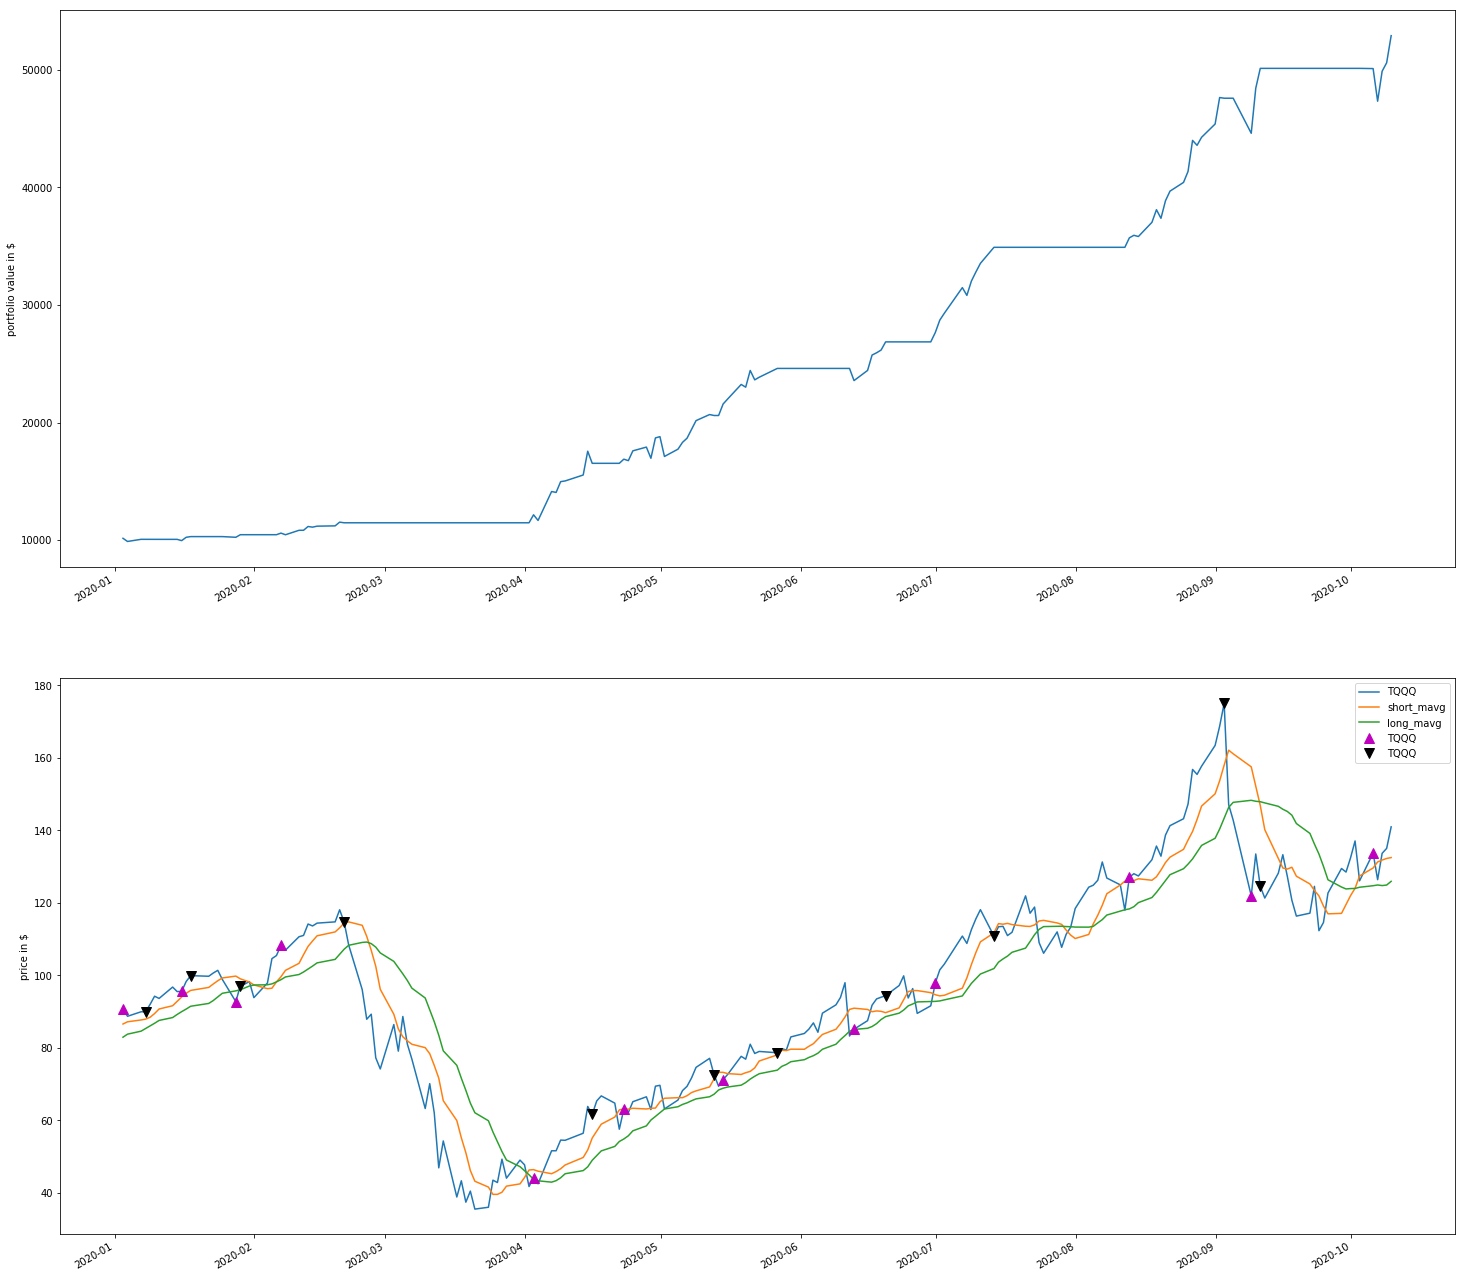

TQQQ  algo_volatility  algorithm_period_return  \
2020-01-02 21:00:00+00:00   90.6365              NaN                 0.015599   
2020-01-03 21:00:00+00:00   88.7100         0.473219                -0.011374   
2020-01-06 21:00:00+00:00   89.9500         0.399903                 0.006830   
2020-01-07 21:00:00+00:00   89.9500         0.327260                 0.006541   
2020-01-08 21:00:00+00:00   91.9780         0.283701                 0.006541   
2020-01-09 21:00:00+00:00   94.2460         0.253920                 0.006541   
2020-01-10 21:00:00+00:00   93.6360         0.231907                 0.006541   
2020-01-13 21:00:00+00:00   96.7685         0.214781                 0.006541   
2020-01-14 21:00:00+00:00   95.5230         0.200965                 0.006541   
2020-01-15 21:00:00+00:00   95.5825         0.197972                -0.004165   
2020-01-16 21:00:00+00:00   98.3085         0.232691                 0.024071   
2020-01-17 21:00:00+00:00   99.9200         0.222448                 0.029994   
2020-01-21 21:00:00+00:00   99.7550         0.213275                 0.029994   
2020-01-22 21:00:00+00:00  100.6425         0.205152                 0.029994   
2020-01-23 21:00:00+00:00  101.3850         0.197893                 0.029994   
2020-01-24 21:00:00+00:00   98.9000         0.191355                 0.029994   
2020-01-27 21:00:00+00:00   92.7500         0.187540                 0.024201   
2020-01-28 21:00:00+00:00   97.1520         0.196611                 0.046109   
2020-01-29 21:00:00+00:00   97.6200         0.191302                 0.046109   
2020-01-30 21:00:00+00:00   98.2750         0.186402                 0.046109   
2020-01-31 21:00:00+00:00   93.8540         0.181860                 0.046109   
2020-02-03 21:00:00+00:00   97.8900         0.177635                 0.046109   
2020-02-04 21:00:00+00:00  104.6200         0.173691                 0.046109   
2020-02-05 21:00:00+00:00  105.4625         0.169999                 0.046109   
2020-02-06 21:00:00+00:00  108.3200         0.170048                 0.059645   
2020-02-07 21:00:00+00:00  106.9550         0.173430                 0.045774   
2020-02-10 21:00:00+00:00  110.6545         0.199905                 0.083604   
2020-02-11 21:00:00+00:00  111.0150         0.196369                 0.083701   
2020-02-12 21:00:00+00:00  114.1600         0.208352                 0.115905   
2020-02-13 21:00:00+00:00  113.6300         0.206320                 0.110376   
...                             ...              ...                      ...   
2020-08-28 20:00:00+00:00  157.7050         0.461001                 3.425669   
2020-08-31 20:00:00+00:00  163.4350         0.460045                 3.538509   
2020-09-01 20:00:00+00:00  168.7200         0.461288                 3.763629   
2020-09-02 20:00:00+00:00  175.0450         0.460112                 3.757866   
2020-09-03 20:00:00+00:00  147.1000         0.458905                 3.757866   
2020-09-04 20:00:00+00:00  142.8125         0.457708                 3.757866   
2020-09-08 20:00:00+00:00  121.9410         0.464612                 3.459728   
2020-09-09 20:00:00+00:00  133.4795         0.472387                 3.842564   
2020-09-10 20:00:00+00:00  124.5650         0.472012                 4.011678   
2020-09-11 20:00:00+00:00  121.3300         0.470804                 4.011678   
2020-09-14 20:00:00+00:00  128.1875         0.469605                 4.011678   
2020-09-15 20:00:00+00:00  133.2850         0.468414                 4.011678   
2020-09-16 20:00:00+00:00  127.2840         0.467233                 4.011678   
2020-09-17 20:00:00+00:00  120.7345         0.466060                 4.011678   
2020-09-18 20:00:00+00:00  116.3465         0.464896                 4.011678   
2020-09-21 20:00:00+00:00  117.1555         0.463741                 4.011678   
2020-09-22 20:00:00+00:00  124.5495         0.462594                 4.011678   
2020-09-23 20:00:00+00:00  112.3215         0.461455          

In [7]:
%zipline --start 2020-1-1 --end 2020-10-10  --data-frequency minute -o bundle_check.pickle --capital-base 10000 --bundle avcsv_minute

In [3]:
!zipline bundles

avcsv 2020-11-01 04:59:30.420125
avcsv_minute 2020-12-07 02:36:38.406064
avcsv_minute 2020-12-07 02:34:17.589238
avcsv_minute 2020-12-07 02:28:09.101832
avcsv_minute 2020-12-07 02:17:19.639563
avcsv_minute 2020-12-07 02:16:50.508576
avcsv_minute 2020-12-07 02:16:08.958014
csvdir <no ingestions>
quandl 2020-11-01 03:08:17.962359
quantopian-quandl <no ingestions>


        date symbol                    pattern  buy_level  stop_loss  \
0 2019-12-16   ADSK          BULLISH STOP LOSS        NaN     181.55   
1 2019-12-16   CTRE          BULLISH ENGULFING      20.61      20.24   
2 2019-12-16    FAS    BEARISH THREE GAP UPS *        NaN      90.71   
3 2019-12-16     FB  BULLISH ONE WHITE SOLDIER     197.92     194.81   
4 2019-12-16    FNV   BEARISH DARK CLOUD COVER        NaN      99.01   

   sell_level  confirmation_level confirmation_date signal     type  \
0         NaN              182.68        2019-12-18    BUY  BULLISH   
1         NaN               20.71        2019-12-18    BUY  BULLISH   
2      90.385                 NaN               NaT    NaN      NaN   
3         NaN              200.74        2019-12-18    BUY  BULLISH   
4      97.880               97.41        2019-12-17  SHORT  BEARISH   

   patterns_total  confirmed_total  profitable_signals confirmation  \
0            18.0             16.0                11.0          88%  

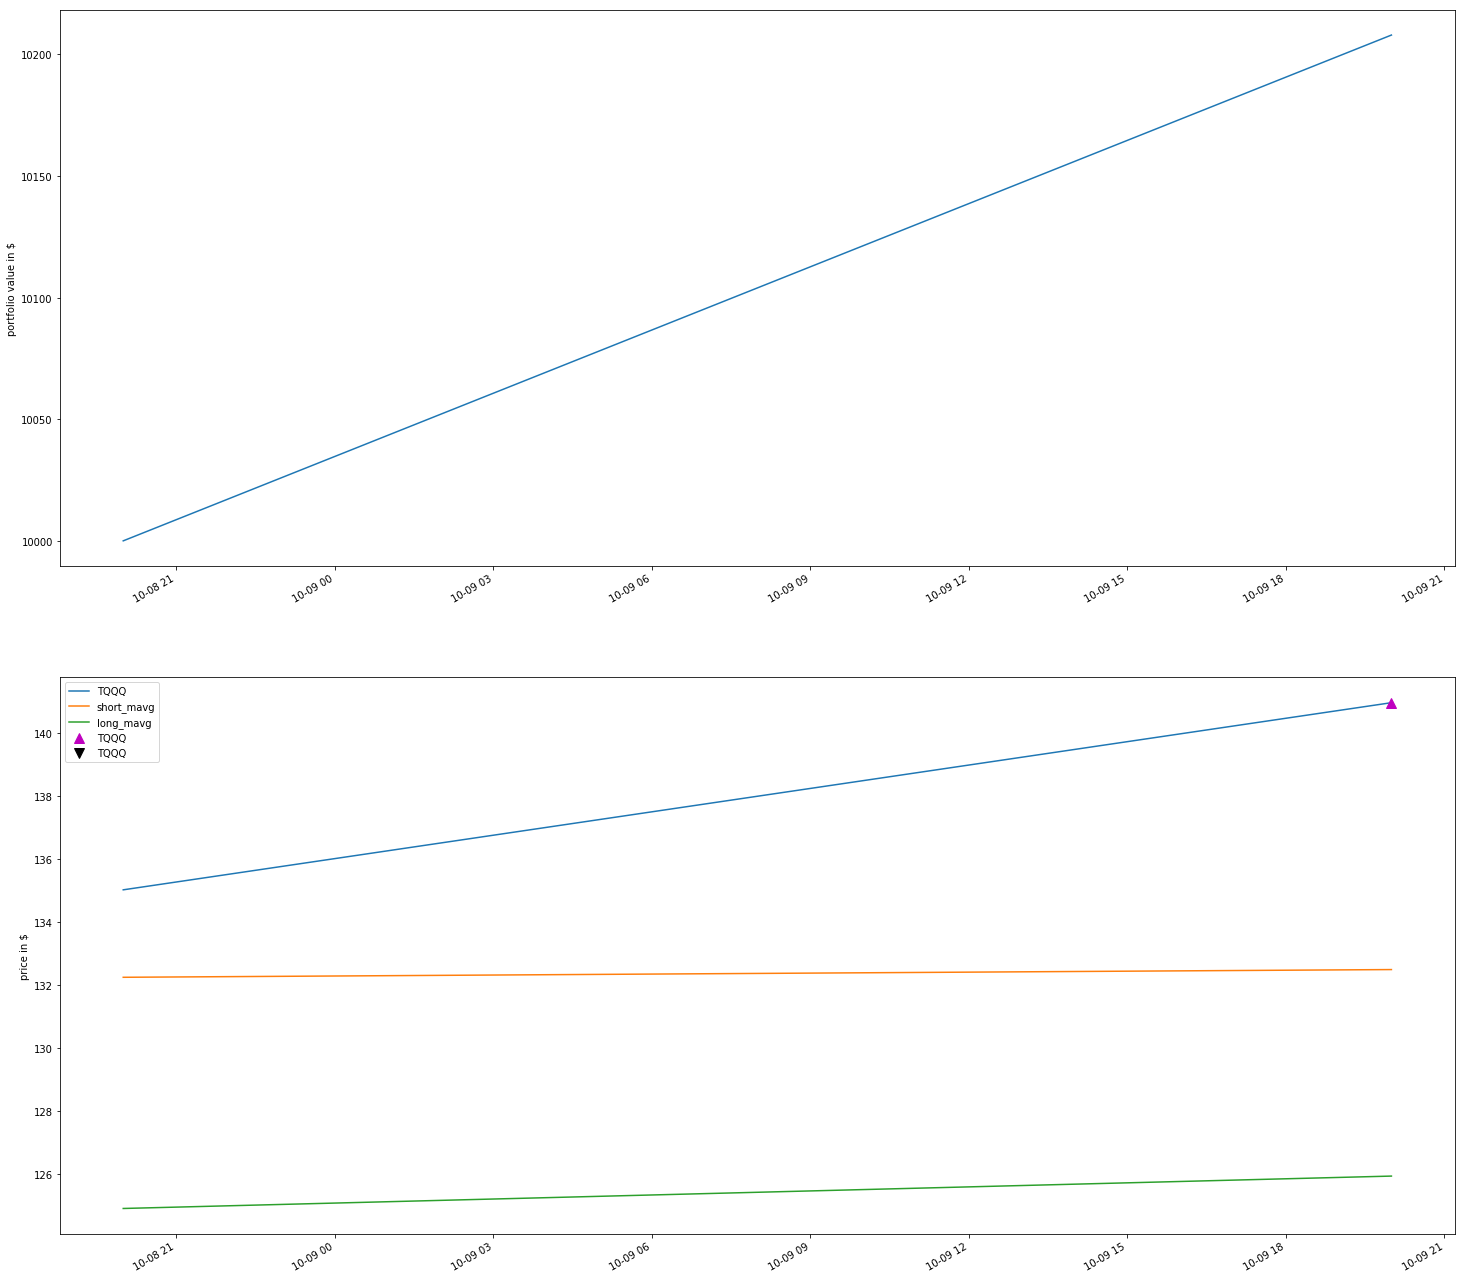

TQQQ  algo_volatility  algorithm_period_return  \
2020-10-08 20:00:00+00:00  135.025              NaN                 0.000000   
2020-10-09 20:00:00+00:00  140.965         0.233473                 0.020799   

                          alpha  atr_stoploss  benchmark_period_return  \
2020-10-08 20:00:00+00:00  None    135.931895                      0.0   
2020-10-09 20:00:00+00:00  None    135.976950                      0.0   

                           benchmark_volatility  beta  capital_used  \
2020-10-08 20:00:00+00:00                   NaN  None      0.000000   
2020-10-09 20:00:00+00:00                   0.0  None  -9967.765356   

                            ending_cash           ...            short_mavg  \
2020-10-08 20:00:00+00:00  10000.000000           ...            132.248891   
2020-10-09 20:00:00+00:00     32.234644           ...            132.493800   

                           short_value  shorts_count  sortino  starting_cash  \
2020-10-08 20:00:00+00:00          0.0             0     None        10000.0   
2020-10-09 20:00:00+00:00          0.0             0     None        10000.0   

                           starting_exposure  starting_value  trading_days  \
2020-10-08 20:00:00+00:00                0.0             0.0             1   
2020-10-09 20:00:00+00:00                0.0             0.0             2   

                                                                transactions  \
2020-10-08 20:00:00+00:00                                                 []   
2020-10-09 20:00:00+00:00  [{'amount': 72, 'commission': None, 'price': 1...   

                           treasury_period_return  
2020-10-08 20:00:00+00:00                     0.0  
2020-10-09 20:00:00+00:00                     0.0  

[2 rows x 41 columns]

In [38]:
%zipline --start 2020-10-8 --end 2020-10-9  --data-frequency minute -o bundle_check.pickle --capital-base 10000 --bundle avcsv_minute

        date symbol                    pattern  buy_level  stop_loss  \
0 2019-12-16   ADSK          BULLISH STOP LOSS        NaN     181.55   
1 2019-12-16   CTRE          BULLISH ENGULFING      20.61      20.24   
2 2019-12-16    FAS    BEARISH THREE GAP UPS *        NaN      90.71   
3 2019-12-16     FB  BULLISH ONE WHITE SOLDIER     197.92     194.81   
4 2019-12-16    FNV   BEARISH DARK CLOUD COVER        NaN      99.01   

   sell_level  confirmation_level confirmation_date signal     type  \
0         NaN              182.68        2019-12-18    BUY  BULLISH   
1         NaN               20.71        2019-12-18    BUY  BULLISH   
2      90.385                 NaN               NaT    NaN      NaN   
3         NaN              200.74        2019-12-18    BUY  BULLISH   
4      97.880               97.41        2019-12-17  SHORT  BEARISH   

   patterns_total  confirmed_total  profitable_signals confirmation  \
0            18.0             16.0                11.0          88%  

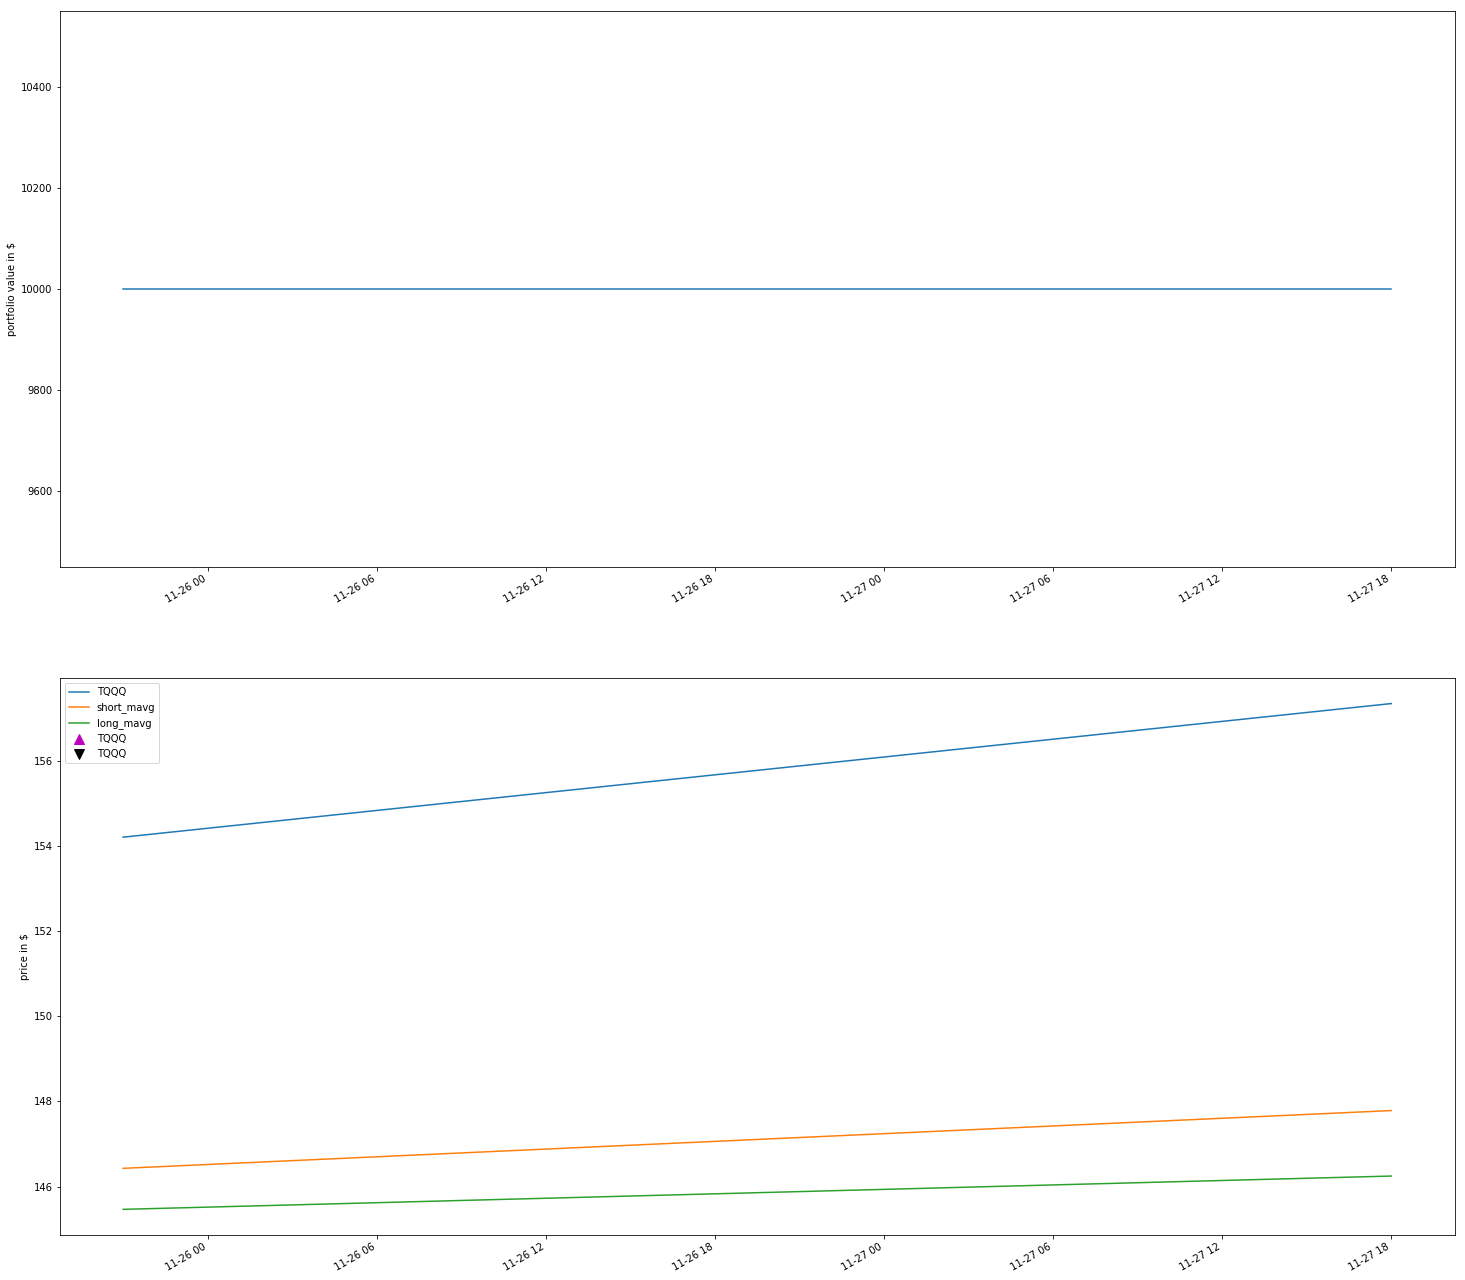

TQQQ  algo_volatility  algorithm_period_return  \
2020-11-25 21:00:00+00:00  154.21              NaN                      0.0   
2020-11-27 18:00:00+00:00  157.35              0.0                      0.0   

                           alpha  atr_stoploss  benchmark_period_return  \
2020-11-25 21:00:00+00:00    NaN    152.721104                -0.002777   
2020-11-27 18:00:00+00:00    0.0    156.953089                 0.000000   

                           benchmark_volatility  beta  capital_used  \
2020-11-25 21:00:00+00:00                   NaN   NaN           0.0   
2020-11-27 18:00:00+00:00              0.062436   0.0           0.0   

                           ending_cash           ...            short_mavg  \
2020-11-25 21:00:00+00:00      10000.0           ...            146.426890   
2020-11-27 18:00:00+00:00      10000.0           ...            147.784472   

                           short_value  shorts_count  sortino  starting_cash  \
2020-11-25 21:00:00+00:00          0.0             0     None        10000.0   
2020-11-27 18:00:00+00:00          0.0             0     None        10000.0   

                           starting_exposure  starting_value  trading_days  \
2020-11-25 21:00:00+00:00                0.0             0.0             1   
2020-11-27 18:00:00+00:00                0.0             0.0             2   

                           transactions  treasury_period_return  
2020-11-25 21:00:00+00:00            []                     0.0  
2020-11-27 18:00:00+00:00            []                     0.0  

[2 rows x 41 columns]

In [46]:
%zipline --start 2020-11-25 --end 2020-11-27  --data-frequency minute -o bundle_check.pickle --capital-base 10000 --bundle avcsv_minute